In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# random polygon generation
np.random.seed(42)
num_polygons = 500
area_bounds = (0, 10, 0, 10)
num_edges = 4
radius = 0.3

x_min, x_max, y_min, y_max = area_bounds
polygons = []

for _ in range(num_polygons):
    center = (
        np.random.uniform(x_min, x_max),
        np.random.uniform(y_min, y_max)
    )
    angles = np.sort(np.random.uniform(0, 2 * np.pi, num_edges))
    vertices = []
    for angle in angles:
        vertices.append((
            center[0] + radius * np.cos(angle),
            center[1] + radius * np.sin(angle)
        ))
    polygons.append(vertices)
    
polygons = np.array(polygons)

In [3]:
# for every q in qs return if line p to q is intercepted by any edge
# this is done by solving the equation b = W x with b = p - edgepoit1
# and W = (p - q, edgepoint2 - edgepoint1) for every q and every edge

def intersecting(p, qs, edges, num_batches=8, tol=1e-8):
    # sort edges based on distance to p
    sorted_idcs = np.argsort(
        (edges[:, 0, 0] - p[0])**2 + (edges[:, 0, 1] - p[1])**2
    )
    edges = edges[sorted_idcs]

    # batchsize increases exponentially
    batch_bounds = np.unique(
        np.geomspace(1, len(edges), num=num_batches + 1, dtype=int)
    )
    remaining = np.ones(len(qs), dtype=bool)
    
    v = p - qs
    w = edges[:, 1] - edges[:, 0]
    b = p - edges[:, 0]
    
    for start, end in zip(batch_bounds[:-1], batch_bounds[1:]):
        # only check qs that werent intersected yet
        v1, v2 = v[remaining, 0], v[remaining, 1]              # shape n x 2
        w1, w2 = w[start:end, 0], w[start:end, 1]              # shape m x 2
        b1, b2 = b[start:end, 0], b[start:end, 1]              # shape m x 2
        
        x1detW = w2 * b1 - w1 * b2                             # shape m
        x2detW = np.array([-v2, v1]).T @ [b1, b2]              # shape n x m

        # det of 2x2 is v1 w2 - v2 w1
        detW = np.outer(v1, w2) - np.outer(v2, w1)             # shape n x m
        sgn = np.sign(detW)                                    # shape n x m
       
        # invert values with detW < 0
        y1 = sgn * x1detW                                      # shape n x m
        y2 = sgn * x2detW                                      # shape n x m
        
        # for every q and every edge save if they intersect
        bound = (1 - tol) * np.abs(detW)                       # shape n x m
        intersects = (                                         # shape n x m
            (tol < y1) & (y1 < bound) &
            (tol < y2) & (y2 < bound)
        )

        remaining[remaining] = ~np.any(intersects, axis=1)     # shape n 

    return ~remaining

In [4]:
# finds the points connecting to p via an edge and returns a bitmask that 
# indicates for every node if it is inside the cone spanned by the edges

def cone_check(p, nodes, edges, cone_tol=1e-8):
    # create cone of two edges
    neigh1_idx = np.where(np.all(edges[:, 0] == p, axis=1))[0][0]
    neigh2_idx = np.where(np.all(edges[:, 1] == p, axis=1))[0][0]
    
    neighbors = [edges[neigh1_idx, 1], edges[neigh2_idx, 0]]
    cone = (neighbors - p).T

    # if det(cone) == 0 no points are within it
    if np.linalg.det(cone) == 0:
        return np.zeros(len(nodes), dtype=bool)

    connect = (nodes - p).T
    lin_comb = np.linalg.solve(cone, connect)

    return (
        (cone_tol < lin_comb[0]) & 
        (cone_tol < lin_comb[1])
    )

In [5]:
# algorithm assumtions:
#   - no edge angles > 180
#   - every node is saved exactly once in both edges[:, 0] and edges[:, 1] (2 edges per node)

def find_path(start, end, nodes, edges, greed=0):
    # add start and end to nodes
    nodes = np.vstack(([start], [end], nodes))
    edges = np.vstack((edges, [[start, start]]))
    
    n = len(nodes)
    
    G = np.full(n, np.inf)
    H = np.linalg.norm(nodes - end, axis=1)
    # mask explored nodes
    F = np.ma.MaskedArray(
        np.full(n, np.inf), 
        np.zeros(n, dtype=bool)
    )
    pred = np.full(n, -1, dtype=int)
    
    curr_idx = 0
    G[curr_idx] = 0
    
    while curr_idx != 1:
        current = nodes[curr_idx]
        
        # if all values in F are inf argmin will return maksed index
        if F.mask[curr_idx] == True:
            # changes goal node to closest node to end point
            dists = np.linalg.norm(nodes[pred != -1] - end, axis=1)
            min_dist = np.min(dists)
            potential_idcs = np.arange(len(nodes))[pred != -1][dists == min_dist]
            curr_idx = potential_idcs[np.argmin(nodes[potential_idcs])]
            
            print('No valid path found, instead pathing to closest node')
            break
        
        # use helper functions to obtain indices of visable nodes
        in_cone = cone_check(current, nodes, edges)
        visable = ~intersecting(current, nodes[~in_cone], edges)
        idcs = np.nonzero(~in_cone)[0][visable]
        
        # update predecessor array and G based on distances from current to next points
        new_Gs = G[curr_idx] + np.linalg.norm(nodes[idcs] - current, axis=1)
        improved = new_Gs < G[idcs]
        
        G[idcs[improved]] = new_Gs[improved]
        pred[idcs[improved]] = curr_idx

        # greed = 0 is A* wich finds the best path, greed = 1 is greedy search
        F.data[idcs] = (1 - greed) * G[idcs] + (1 + greed) * H[idcs]
        F.mask[curr_idx] = True
        curr_idx = np.argmin(F)
    
    # backtracking predecessor array
    path = [nodes[curr_idx]]
    while curr_idx != 0:
        curr_idx = pred[curr_idx]
        path.append(nodes[curr_idx])
    
    return np.array(path[::-1]), pred, F.mask

explored nodes: 415


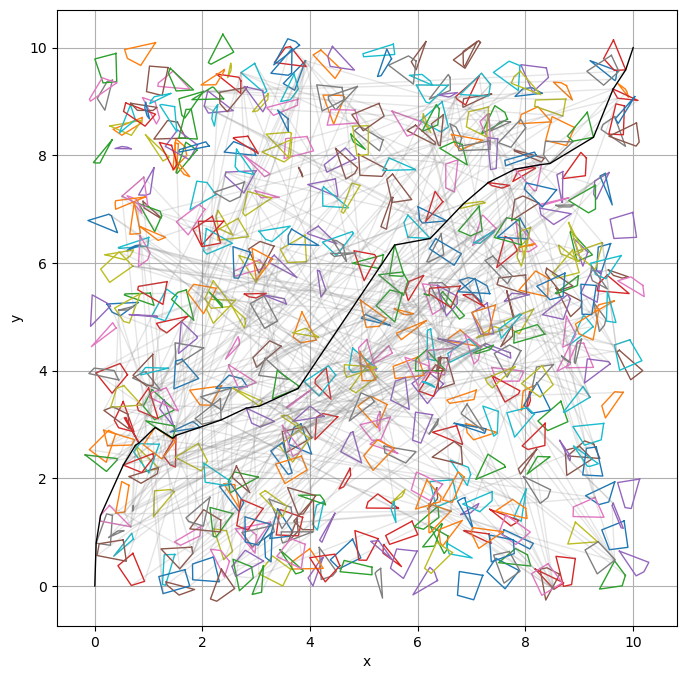

In [6]:
nodes = polygons.reshape(-1, 2)
edges_list = []

for polygon in polygons:
    new_edges = np.stack([polygon, np.roll(polygon, 1, axis=0)], axis=1)
    edges_list.append(new_edges)

edges = np.vstack(edges_list)

s = np.array([0, 0], dtype=float)
e = np.array([10, 10], dtype=float)

#nodes = np.vstack(([s], [e], nodes))
#edges = np.vstack((edges, [[s, s]]))

path, pred, mask = find_path(s, e, nodes, edges, greed=0)
print('explored nodes:', np.sum(mask))

plt.figure(figsize=(8, 8))
for polygon in polygons:
    poly = np.vstack([polygon, polygon[0]])  # Close the polygon by repeating the first vertex
    plt.plot(poly[:, 0], poly[:, 1], linewidth=1)
plt.xlabel("x")
plt.ylabel("y")
plt.grid(True)
plt.axis('equal')  
for c, p in enumerate(pred):
    if p != -1 and mask[c] == 1:
        plt.plot([nodes[c, 0], nodes[p, 0]], [nodes[c, 1], nodes[p, 1]], c='gray', linewidth=1, alpha=0.2)

#plt.scatter(nodes[:, 0][mask], nodes[:, 1][mask], c='black', s=10, marker='o')
plt.plot(path[:, 0], path[:, 1], c='black', linewidth=1)
#plt.scatter(s[0], s[1], c='red')
#plt.scatter(e[0], e[1], c='red')
plt.show()

In [7]:
def create_map(marker_poses, marker_width=0.1):
    corners = 0.5 * marker_width * np.array([[-1, -1], [-1, 1], [1, 1], [1, -1]])    
    
    nodes = (marker_poses[:, None] + corners[None]).reshape(-1, 2)
    
    shifted_indices = np.arange(len(nodes), step=4).repeat(4) + np.tile([1, 2, 3, 0], len(nodes) // 4)
    
    edges = np.stack([nodes, nodes[shifted_indices]], axis=1)

    return nodes, edges

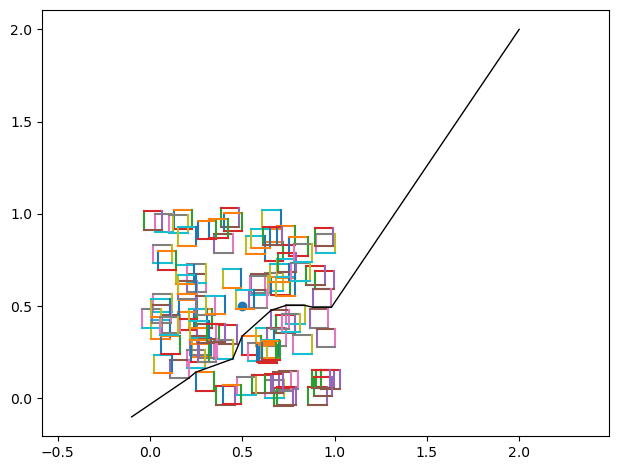

In [8]:
num_markers = 100
marker_poses = np.random.rand(num_markers, 2)

nodes, edges = create_map(marker_poses)

s = np.array([-0.1, -0.1], dtype=float)
e = np.array([2, 2], dtype=float)

path, pred, mask = find_path(s, e, nodes, edges, greed=0)

#plt.scatter(nodes[:, 0], nodes[:, 1], s=10)
for edge in edges:
    plt.plot(edge[:, 0], edge[:, 1])

plt.plot(path[:, 0], path[:, 1], c='black', linewidth=1)
plt.axis('equal')
plt.scatter(0.5, 0.5)
#plt.axis('off')
plt.tight_layout()
plt.show()

In [2]:
def reachable(p, qs, obstacles, threshold=0.5):
    v = qs - p                                              # shape n x 2
    w = p - obstacles                                       # shape m x 2

    vTv = (v[:, 0]**2 + v[:, 1]**2)[:, None]                # shape n x 1
    vTw = v @ w.T                                           # shape n x m
    
    ts = np.clip(-vTw / vTv, 0, 1)                          # shape n x m   
    
    con_x = p[0] + ts * v[:, 0][:, None] - obstacles[:, 0]  # shape n x m
    con_y = p[1] + ts * v[:, 1][:, None] - obstacles[:, 1]  # shape n x m
    
    dists = con_x**2 + con_y**2                             # shape n x m
    min_dists = np.min(dists, axis=1)                       # shape n

    mask = min_dists > threshold                            # shape n
    return mask, min_dists[mask]

In [3]:
def grid_path(start, end, nodes, obstacles, obstacle_radius=0.2, bias=1e-2, avoidance=1e-2):
    # add start and end to nodes
    nodes = np.vstack(([start], [end], nodes))
    
    n = len(nodes)
    
    G = np.full(n, np.inf)
    H = np.linalg.norm(nodes - end, axis=1)
    # mask explored nodes
    F = np.ma.MaskedArray(
        np.full(n, np.inf), 
        np.zeros(n, dtype=bool)
    )
    pred = np.full(n, -1, dtype=int)

    curr_idx = 0
    G[curr_idx] = 0
    
    while curr_idx != 1:
        # if all values in F are inf argmin will return maksed index
        if F.mask[curr_idx] == True:
            # changes goal node to closest node to end point
            dists = np.linalg.norm(nodes[pred != -1] - end, axis=1)
            # if final point is unreachable
            if len(dists) == 0:
                curr_idx = 1 + np.argmin(np.linalg.norm(nodes[1:] - start, axis=1))
                G[curr_idx] = 0
                print('Start node inside obstacle, instead starting from closest node')
            # else start point is inside obstacle
            else:
                curr_idx = np.arange(len(nodes))[pred != -1][np.argmin(dists)]
                print('No valid path found, instead pathing to closest node')
                break
                
        current = nodes[curr_idx]
        
        # use helper functions to obtain indices of visable nodes
        visable, min_dists = reachable(current, nodes, obstacles, threshold=obstacle_radius**2)
        idcs = np.nonzero(visable)[0]
        
        # update predecessor array and G based on distances from current to next points
        new_Gs = G[curr_idx] + np.linalg.norm(nodes[idcs] - current, axis=1) + bias + avoidance * np.exp(min_dists - obstacle_radius**2)
        improved = new_Gs < G[idcs]
        
        G[idcs[improved]] = new_Gs[improved]
        pred[idcs[improved]] = curr_idx

        # greed = 0 is A* wich finds the best path, greed = 1 is greedy search
        F.data[idcs] = G[idcs] + H[idcs]
        F.mask[curr_idx] = True
        curr_idx = np.argmin(F)
    
    # backtracking predecessor array
    path = [nodes[curr_idx]]
    while pred[curr_idx] != -1:
        curr_idx = pred[curr_idx]
        path.append(nodes[curr_idx])
    
    return np.array(path[::-1])

In [225]:
# obstacle generation
num_borders = 20
num_obstacles = 20


#borders = np.random.rand(num_borders, 2) * 2 - 1
borders = np.vstack((np.linspace(-2, 1, num=num_borders), -0.5 * np.ones(num_borders))).T
obstacles = np.random.rand(num_obstacles, 2) * 2 - 0.5

In [226]:
def create_map(borders, obstacles, center=np.array([5, 5]), nodes_per_obstacle=10, min_radius=0.5):
    # sample nodes around borders facing center
    to_center = center - borders
    phi = np.arctan2(to_center[:, 1], to_center[:, 0])
    
    phis = np.linspace(phi - np.pi / 2, phi + np.pi / 2, nodes_per_obstacle // 2).T

    rs = min_radius + 0.2 * np.exp(np.random.normal(0, 0.5, size=(len(borders), nodes_per_obstacle//2)))
    
    borders_x = borders[:, 0, None] + rs * np.cos(phis)
    borders_y = borders[:, 1, None] + rs * np.sin(phis)

    border_points = np.stack((borders_x, borders_y), axis=-1).reshape(-1, 2)
    
    # sample nodes around obstacles
    phis = np.linspace(0, 2 * np.pi, nodes_per_obstacle, endpoint=False)

    rs = min_radius + 0.2 * np.exp(np.random.normal(0, 0.5, size=(len(obstacles), nodes_per_obstacle)))
    
    obstacles_x = obstacles[:, 0, None] + rs * np.cos(phis)
    obstacles_y = obstacles[:, 1, None] + rs * np.sin(phis)
    
    obstacle_points = np.stack((obstacles_x, obstacles_y), axis=-1).reshape(-1, 2)

    nodes = np.vstack((border_points, obstacle_points))
    # filter out nodes that are inside obstacles
    con = nodes[:, None] - np.vstack((borders, obstacles))[None]
    dists = con[..., 0]**2 + con[..., 1]**2
    min_dists = np.min(dists, axis=1)

    #return nodes
    return nodes[min_dists > min_radius**2]

4


/tmp/ipykernel_682/1370424161.py:8: RuntimeWarning: invalid value encountered in divide
  ts = np.clip(-vTw / vTv, 0, 1)                          # shape n x m


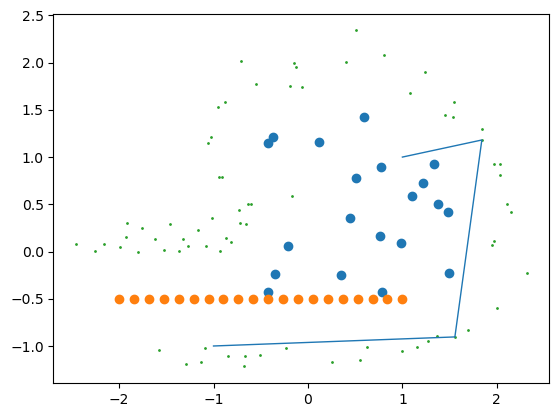

In [227]:
start = np.array([-1, -1], dtype=float)
end = np.array([1, 1], dtype=float)
nodes = create_map(borders, obstacles)
path = grid_path(start, end, nodes, np.vstack((borders, obstacles)), obstacle_radius=0.12, bias=0.2, avoidance=0)
print(len(path))

plt.scatter(obstacles[:, 0], obstacles[:, 1])
plt.scatter(borders[:, 0], borders[:, 1])

plt.scatter(nodes[:, 0], nodes[:, 1], s=1)
plt.plot(path[:, 0], path[:, 1], linewidth=1)
plt.axis('equal')
plt.show()

In [228]:
def check_path(path, obstacles, obstacle_radius=0.5):
    for p, q in zip(path[:-1], path[1:]):
        r, _ = reachable(p, q[None], obstacles, threshold=obstacle_radius**2)
        
        if not r[0]:
            return False
    return True

In [229]:
class Explorer:
    def __init__(self, num_cells, grid_width, grid_offset=np.array((-1, 0))):
        self.grid = np.zeros((num_cells, num_cells))
        self.width = grid_width
        self.offset = grid_offset

    def update(self, robot_pos, std=0.2):
        x_pos, y_pos = robot_pos - self.offset
        bound = self.width / 2
        
        x, y = np.meshgrid(
            np.linspace(-bound, bound, num=self.grid.shape[0]),
            np.linspace(-bound, bound, num=self.grid.shape[1])
        )
        self.grid += np.exp(-((x - x_pos)**2 + (y - y_pos)**2) / std)
        self.grid -= self.grid.mean()

    def get_point(self, robot_pos, borders, obstacles, num_points=5, obstacle_radius=0.12, e=1, d=0.2, a=0.005):
        # sample points
        n, m = self.grid.shape
        bound = self.width / 2

        points = np.random.uniform(-bound, bound, size=(num_points, 2))
        
        # filter out points inside obstacles
        con = points[:, None] - obstacles[None]
        dists = con[..., 0]**2 + con[..., 1]**2
        obstacle_dists = np.min(dists, axis=1)

        points = points[obstacle_dists > obstacle_radius**2]
        
        # filter out points outside arena
        mask, _ = reachable([0, 0], points, borders, threshold=obstacle_radius**2)
        points = points[mask]

        x_idcs = ((points[:, 0] + bound) * (n - 1) / self.width).astype(int)
        y_idcs = ((points[:, 1] + bound) * (m - 1) / self.width).astype(int)

        # explo loss avoid already explored regions
        expl_loss = e * self.grid[y_idcs, x_idcs]

        # dist loss choses close points
        con = points - robot_pos - self.offset
        dist_loss = d * np.linalg.norm(con, axis=1)

        # avoid loss choses points far away from obstacles and borders
        con = points[:, None] - borders[None]
        dists = con[..., 0]**2 + con[..., 1]**2
        border_dists = np.min(dists, axis=1)

        avoid_loss = a / (np.minimum(obstacle_dists[obstacle_dists > obstacle_radius**2][mask], border_dists))

        # sum losses
        loss = expl_loss + dist_loss + avoid_loss
        
        #best_point = points[np.argmin(expl_loss)] + self.offset

        return points[:, 0], points[:, 1], loss

In [230]:
explorer = Explorer(50, 4, np.array([0, 0]))
explorer.update(np.array([-1, 0]))

x, y, loss = explorer.get_point(np.array((-1, 0)), borders, obstacles, num_points=500)

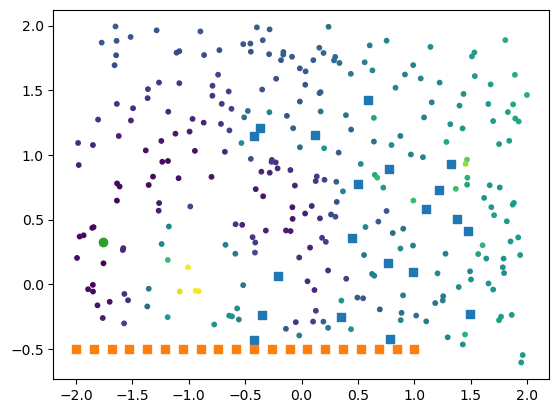

In [231]:
plt.scatter(obstacles[:, 0], obstacles[:, 1], marker='s')
plt.scatter(borders[:, 0], borders[:, 1], marker='s')


plt.scatter(x, y, c=loss, s=10)
plt.scatter(x[np.argmin(loss)], y[np.argmin(loss)])
#plt.xlim(-1, 1)
#plt.ylim(-1, 1)

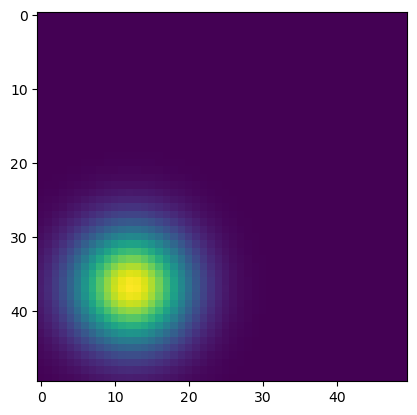

In [132]:
plt.imshow(explorer.grid)